(dl/02-optim)=
# Optimization

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/02-optim.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**References:**  [[CS182-lec4]](https://cs182sp21.github.io/static/slides/lec-4.pdf) [[UvA-Tutorial4]](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html)

## Introduction

Recall that we can visualize $\mathcal{L}_{\mathcal{D}}(\boldsymbol{\Theta})$ as a surface ({numref}`02-loss-surface`). 
This is also known as the **loss landscape**. Gradient descent finds the minimum by 
locally moving in the direction of greatest decrease in loss ({numref}`02-gradient-descent-1d`). The step size depends on
the learning rate that has to be tuned well: a too large value can result in overshooting
the minimum, while a too small learning rate can result in slow convergence or being stuck in a
local minimum. In this notebook, we will discuss situations where gradient descent works, 
situations where it works poorly, and ways we can improve it.

<br>

```{figure} ../../img/nn/02-loss-surface.png
---
name: 02-loss-surface
width: 60%
---
Loss surface for a model with two weights. Source: [[CS182-lec4]](https://cs182sp21.github.io/static/slides/lec-4.pdf)
```

```{figure} ../../img/nn/02-gradient-descent-1d.png
---
name: 02-gradient-descent-1d
width: 60%
---
Gradient descent in 1-dimension. 
Next step moves opposite to the direction of the slope. Moreover, step size is scaled
based on the magnitude of the slope. Source: [[CS182-lec4]](https://cs182sp21.github.io/static/slides/lec-4.pdf)
```

## Gradient descent demo

To experiment with GD algorithms, we create a template class. The template implements a method for zeroing out the gradients. 
The only method that needs to be changed is how to update parameters in `update_param` for specific algorithms.

In [1]:
import torch
import torch.nn as nn

class OptimizerTemplate:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            self.update_param(p)

    def update_param(self, p):
        raise NotImplementedError

Our first algorithm is GD which we discussed in the previous notebook:

In [2]:
class GD(OptimizerTemplate):
    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_delta = -self.lr * p.grad
        p.add_(p_delta) # In-place update => saves memory, does not create comp graph

We will test with the following synthetic loss surface (i.e. not generated with data):

In [3]:
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html
def pathological_loss(w0, w1):
    l1 = torch.tanh(w0) ** 2 + 0.01 * torch.abs(w1)
    l2 = torch.sigmoid(w1)
    return l1 + l2

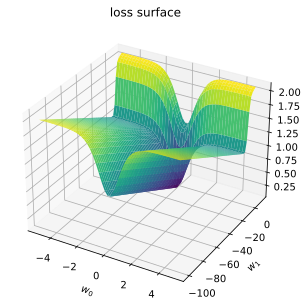

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from mpl_toolkits.mplot3d import Axes3D 
backend_inline.set_matplotlib_formats('svg')


def plot_surface(ax, f, title="", x_min=-5, x_max=5, y_min=-5, y_max=5, N=50):
    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            Z[i, j] = f(torch.tensor(X[i, j]), torch.tensor(Y[i, j]))
    
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')
    ax.set_title(title)
    

def plot_contourf(ax, f, w_hist, color, title="", x_min=-5, x_max=5, y_min=-5, y_max=5, N=50, **kw):
    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            Z[i, j] = f(torch.tensor(X[i, j]), torch.tensor(Y[i, j]))

    for t in range(1, len(w_hist)):
        ax.plot([w_hist[t-1][0], w_hist[t][0]], [w_hist[t-1][1], w_hist[t][1]], color=color)

    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(w_hist[:, 0], w_hist[:, 1], marker='o', s=5, facecolors=color, color=color, **kw)
    ax.set_title(title)
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
plot_surface(ax, pathological_loss, x_min=-5, x_max=5, y_min=-100, y_max=10, title="loss surface")

The following optimization algorithm purely operates on the loss surface as a function of weights. 
It starts with initial weights `w_init`, then updates this weight iteratively by computing the
gradient of the loss function (which constructs a computational graph). The weight update step
depends on the particular optimizer class used.

In [5]:
def train_curve(optimizer, w_init=[5.0, 5.0], loss_fn=pathological_loss, num_steps=100):
    weights = nn.Parameter(torch.FloatTensor(w_init), requires_grad=True)
    optimizer = optimizer([weights])

    list_points = [torch.tensor([weights[0], weights[1], loss_fn(weights[0], weights[1])])]
    for _ in range(num_steps):
        loss = loss_fn(weights[0], weights[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))

    points = torch.stack(list_points, dim=0).numpy()
    return points

Gradient descent from the same initial point with different learning rates:

In [6]:
def plot_gd_steps(ax, lr, optim, label, w_init=[-2.5, 2.5], num_steps=300, **plot_kw):
    path = train_curve(optimizer=lambda params: optim(params, lr=lr),  w_init=w_init, num_steps=num_steps)
    plot_contourf(ax[0], f=pathological_loss, w_hist=np.array(path), x_min=-10, x_max=10, y_min=-10, y_max=10, label=label(lr), **plot_kw)
    ax[1].plot(np.array(path)[:, 2], label=label(lr), color=plot_kw.get("color"), zorder=plot_kw.get("zorder", 1))
    ax[1].set_xlabel("steps")
    ax[1].set_ylabel("loss")
    ax[1].grid(linestyle="dotted", alpha=0.8)
    return path

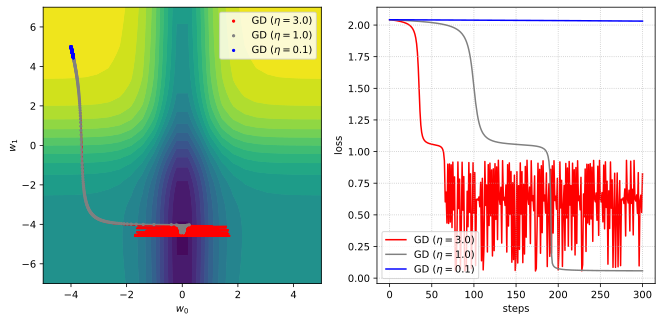

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, lr=3.0, w_init=[-4.0, 5.0], optim=GD, label=lambda lr: f"GD ($\eta={lr}$)", color="red",  zorder=1)
plot_gd_steps(ax, lr=1.0, w_init=[-4.0, 5.0], optim=GD, label=lambda lr: f"GD ($\eta={lr}$)", color="gray", zorder=2)
plot_gd_steps(ax, lr=0.1, w_init=[-4.0, 5.0], optim=GD, label=lambda lr: f"GD ($\eta={lr}$)", color="blue", zorder=3)

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[0].legend()
ax[1].legend();

The direction of steepest descent does not always point to the minimum. Moreover, the learning rate has to be tuned well to avoid oscillations or getting stuck. In the above plot, the optimizer with small learning rate was not able to escape the plateau. Meanwhile, using a large learning rate results in oscillation around the minimum continually overshooting it.

## Loss landscape

For convex functions, gradient descent has strong guarantees of converging. However, the loss surface of neural networks
are generally nonconvex. Clever dimensionality reduction techniques allow us to visualize loss function curvature despite the very large number of parameters ({numref}`02-visualizing-loss` from {cite}`visualizing_loss`). Notice that there are **plateaus** (or flat minimas) and **local minimas** which makes gradient descent hard. In high-dimension **saddle points** are the most common critical points.

```{figure} ../../img/nn/02-visualizing-loss.png
---
name: 02-visualizing-loss
width: 80%
---
The loss surfaces of ResNet-56 with (**right**) and without (**left**) skip connections. 
The loss surface on the right looks better although there are still some flatness. {cite}`visualizing_loss`
```

```{margin}
**Reading**: <br>
[Escaping from Saddle Points](https://www.offconvex.org/2016/03/22/saddlepoints/)
```

```{figure} ../../img/nn/02-optima-type.png
---
name: 02-optima-type
width: 100%
---
Types of critical points. Source: [[CS182-lec4]](https://cs182sp21.github.io/static/slides/lec-4.pdf)
```

### Local minima

Local minimas are very scary, in principle, since gradient descent could converge to a
solution that is arbitrarily worse than the global optimum. Surprisingly, this becomes 
less of an issue as the number of parameters increases. 
They exist, but tend to be not much worse than global optima ({numref}`02-local-minima`).
Here we see that for larger networks the variance between loss values of local optima become
smaller. In other words, local minima tend to be equivalent for large networks.

```{figure} ../../img/nn/02-local-minima.png
---
name: 02-local-minima
width: 80%
---
Test loss of 1000 networks on a scaled-down version of MNIST, where
each image was downsampled to size 10×10. The networks have one hidden layer
and with 25, 50, 100, 250, and 500 hidden units, 
each one starting from a random set of parameters sampled uniformly within the unit cube. 
All networks were trained for 200 epochs using SGD with
learning rate decay. Source: {cite}`pmlr-v38-choromanska15`
```

### Plateaus

Plateaus are regions in the loss landscape with small gradients. It can also be a flat local minima. Below the initial weights is in a plateau, and the optimizer with small learning rate gets stuck and fails to converge. Large learning rate allows the optimizer to escape such regions. So we cannot just choose small learning rate to prevent oscillations. We will see later that **momentum** helps to overcome this tradeoff.

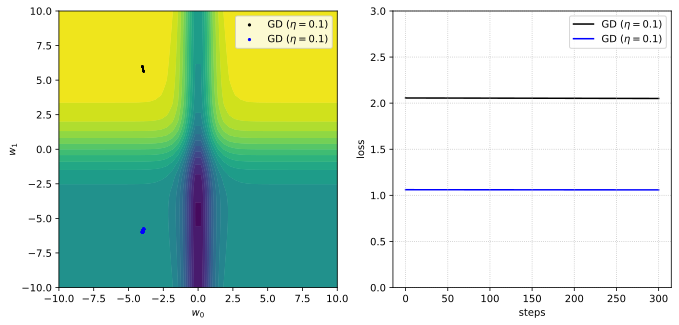

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, lr=0.1, w_init=[-4.0,  6.0], optim=GD, label=lambda lr: f"GD ($\eta={lr}$)", color="black")
plot_gd_steps(ax, lr=0.1, w_init=[-4.0, -6.0], optim=GD, label=lambda lr: f"GD ($\eta={lr}$)", color="blue")
ax[1].set_ylim(0, 3)
ax[0].legend()
ax[1].legend();

### Saddle points

```{margin}
**Reading:** <br>
[Escaping from Saddle Points](https://www.offconvex.org/2016/03/22/saddlepoints/)
```

Saddle points are critical points (i.e. gradient zero) that are local minimum in some dimensions but local maximum in other dimensions. Neural networks have a lot of symmetry which can result in exponentially many local minima. Saddle points naturally arise
in paths that connect these local minima ({numref}`02-connected-minima`). 
It takes a long time to escape a saddle point since it is usually surrounded by high-loss plateaus {cite}`dauphin2014`.
A saddle point looks like a special structure. But in high-dimension, it turns out that most optima are saddle points.

```{figure} ../../img/nn/02-connected-minima.png
---
name: 02-connected-minima
width: 60%
---
Paths between two minimas result in a saddle point. Source: [[offconvex.org]](https://www.offconvex.org/2016/03/22/saddlepoints/)
```

The Hessian $\boldsymbol{\mathsf{H}}$ at the critical point is a matrix containing second derivatives at that point. We will see shortly that these characterize the local curvature. From [Schwarz's theorem](https://en.wikipedia.org/wiki/Symmetry_of_second_derivatives#Schwarz's_theorem), mixed partials are equal assuming the second partial derivatives are continuous around the optima. It follows that $\boldsymbol{\mathsf{H}}$ is symmetric, and from the [Real Spectral Theorem](https://github.com/particle1331/computational-linear-algebra/blob/master/chapters/02-svd.ipynb), diagonalizable with real eigenvalues. 
The only thing to check is whether the eigenvalues are positive, zero, or negative.

If the Hessian has all positive eigenvalues, it is [positive-definite](https://en.wikipedia.org/wiki/Definite_matrix). This easily follows from the spectral decomposition $\boldsymbol{\mathsf{H}} = \boldsymbol{\mathsf{U}} \boldsymbol{\Lambda} \boldsymbol{\mathsf{U}}^\top$ such that $\boldsymbol{\Lambda}$ is the diagonal matrix of eigenvalues of $\boldsymbol{\mathsf{H}}$ and $\boldsymbol{\mathsf{U}}$ is an orthogonal matrix with corresponding unit eigenvectors as columns. This is the multivariable equivalent of "concave up". On the other hand, if it has all negative eigenvalues, it is negative-definite or "concave down". To see this, consider that the Taylor expansion at the critical point is: 

$$
\Delta \mathcal{L}_{\mathcal{D}} = \frac{1}{2} \Delta \boldsymbol{\Theta}^\top \boldsymbol{\mathsf{H}}\, \Delta \boldsymbol{\Theta} + O(\Delta \boldsymbol{\Theta}^3).
$$

If any eigenvalue is zero, more information is needed (i.e. we need third order terms). Finally, if the eigenvalues are mixed, we get a saddle point where there are (orthogonal) directions (corresponding to eigenvectors) where the loss decreases and directions where the loss increases. Since $M \gg 1$, getting eigenvalues all positive or one eigenvalue zero is relatively rare, so that the probability that the critical point is a saddle point is high.

## Momentum methods

### Momentum

Recall that high learning rate allows the optimizer to overcome plateaus. However, this can result in oscillation. The intuition behind **momentum** is that if successive gradient steps point in different
directions, we should cancel off the directions that disagree. Moreover, if successive gradient steps point in similar directions, we
should go faster in that direction. Simply adding gradients can result in extreme step size, so exponential averaging using a parameter $0 \leq \beta < 1$ is used:

$$
\begin{aligned}
\boldsymbol{\mathsf{m}}^t &= \beta \, \boldsymbol{\mathsf{m}}^{t-1} + (1 - \beta) \, \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \\
\boldsymbol{\boldsymbol{\Theta}}^{t+1} &= \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \, \boldsymbol{\mathsf{m}}^{t}.
\end{aligned}
$$

Note that $\beta = 0$ is just regular GD.
In the following implementation, we add an extra parameter `momentum=0.0` to the `GD` class for $\beta$. Observe that the optimizer is now **stateful**: the attribute `self.m` stores the momentum vector $\boldsymbol{\mathsf{m}}^t$ above as a dictionary with parameter keys. We will set $\boldsymbol{\mathsf{m}}^0$ to be the zero vector.

```{margin}
Saving the `state_dict` for the optimizer and model in PyTorch allows to [resume training](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training).
```

In [9]:
class GD(OptimizerTemplate):
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.beta = momentum
        self.m = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.m[p] = self.beta * self.m[p] + (1 - self.beta) * p.grad
        p_delta = -self.lr * self.m[p]
        p.add_(p_delta)

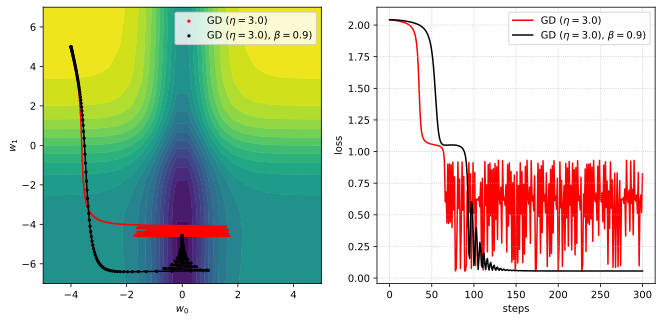

In [10]:
from functools import partial

fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, lr=3.0, w_init=[-4.0, 5.0], optim=GD, label=lambda lr: f"GD ($\eta={lr}$)", color="red",  zorder=1)
plot_gd_steps(ax, lr=3.0, w_init=[-4.0, 5.0], optim=partial(GD, momentum=0.9), label=lambda lr: f"GD ($\eta={lr}$)" + r", $\beta=0.9$)", color="black", zorder=2)

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

The optimizer is able to escape in initial plateau due to a high learning rate. 
Then, it overshoots resulting in delayed decrease in loss.
Between roughly 60-80 steps, the optimizer escapes the lower plateau
by accumulating small gradients toward the minimum.
Finally, it oscillates around the minimum but these eventually die down due to the effect of momentum.

**Remark.** Momentum is aptly named since $\beta$ can be thought of as the mass of a ball rolling down the surface to a minimum. It resists force (gradients), and maintains an inertia (momentum state vector) from previous updates.

### RMSProp

The relative magnitude of gradient is not very informative: only its **sign** is. 
Moreover, it changes during the course of training. Near the minimum it becomes small 
slowing down convergence. 
This makes it difficult to tune learning rate for different functions, or for different
points on the same function. To fix this, 
**RMSProp** normalizes the gradient along each dimension. 
It estimates the size of the gradient using exponential averaging. 

$$
\begin{aligned}
\boldsymbol{\mathsf{v}}^t &= \beta \, \boldsymbol{\mathsf{v}}^{t-1} + (1 - \beta) \, \left( \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \right)^2 \\
\boldsymbol{\boldsymbol{\Theta}}^{t+1} &= \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \, \frac{1}{\sqrt{\boldsymbol{\mathsf{v}}^{t}}} \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}).
\end{aligned}
$$

A similar algorithm called **AdaGrad** {cite}`adagrad` uses the update rule $\boldsymbol{\mathsf{v}}^t = \boldsymbol{\mathsf{v}}^{t-1} + \left( \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \right)^2.$ This simply adds the squared gradients which results in auto-tuning the learning rate near the minimum. This works for convex problems where it has theoretical guarantess since it avoids oscillation with large learning rate. 
But this only works if it finds the optimum quickly before the rate decays too much. RMSProp tends to be better for nonconvex problems.

In [11]:
class RMSProp(OptimizerTemplate):
    def __init__(self, params, lr, beta=0.9):
        super().__init__(params, lr)
        self.beta = beta
        self.v = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.v[p] = self.beta * self.v[p] + (1 - self.beta) * p.grad ** 2
        p_delta = -self.lr * p.grad / torch.sqrt(self.v[p])
        p.add_(p_delta)

Notice that gradient normalization allows escaping plateaus:

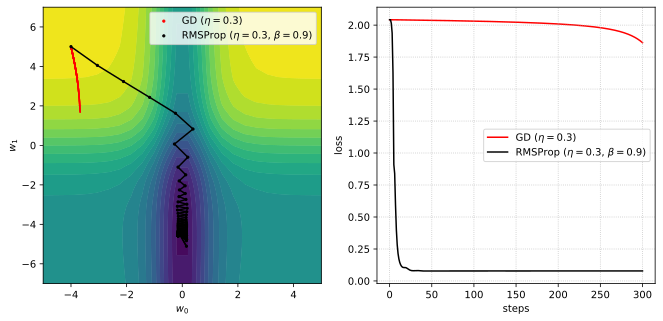

In [12]:
from functools import partial

fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, lr=0.3, w_init=[-4.0, 5.0], optim=GD, label=lambda lr: f"GD ($\eta={lr}$)", color="red",  zorder=1)
plot_gd_steps(ax, lr=0.3, w_init=[-4.0, 5.0], optim=partial(RMSProp, beta=0.9), label=lambda lr: f"RMSProp ($\eta={lr}$, " + r"$\beta=0.9$)", color="black", zorder=2)

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

### Adam

Notice that RMSProp experiences oscillations around the minimum. **Adam** {cite}`adam` fixes this by combining momentum with RMSProp. Adam also uses bias correction so that gradients dominate during early stages of training instead of the state vectors which are initially set to zero. Let $0 \leq \beta_1 < 1$, $0 \leq \beta_2 < 1$, and $0 < \epsilon \ll 1$ and set $\boldsymbol{\mathsf{m}}^0 = \boldsymbol{\mathsf{v}}^0  = \mathbf{0}$:

$$
\begin{aligned}
\boldsymbol{\mathsf{m}}^t &= \beta_1 \, \boldsymbol{\mathsf{m}}^{t-1} + (1 - \beta_1) \, \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \\
\boldsymbol{\mathsf{v}}^t &= \beta_2 \, \boldsymbol{\mathsf{v}}^{t-1} + (1 - \beta_2) \, \left( \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \right)^2 \\
\hat{\boldsymbol{\mathsf{m}}}^t &= \frac{\boldsymbol{\mathsf{m}}^t}{1 - {\beta_1}^t} \\
\hat{\boldsymbol{\mathsf{v}}}^t &= \frac{\boldsymbol{\mathsf{v}}^t}{1 - {\beta_2}^t} \\
\boldsymbol{\boldsymbol{\Theta}}^{t+1} &= \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \, \frac{\hat{\boldsymbol{\mathsf{m}}}^t}{\sqrt{\boldsymbol{\mathsf{v}}^{t}} + \epsilon}.
\end{aligned}
$$

A good set of parameters for Adam is $\eta = 0.001$, $\beta_1 = 0.9$, $\beta_2 = 0.999$ and $\epsilon = 10^{-8}.$ Note that we can now choose the same $\eta$ regardless of the loss function $f$ similar to RMSProp. Here we choose $\beta_2 > \beta_1$ since gradient magnitude usually does not change as fast as its direction so we choose a larger momentum.

**Remark.** To understand bias correction, let $\boldsymbol{\mathsf{g}}^t = \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}).$ Observe that 

$$
\begin{aligned}
\boldsymbol{\mathsf{m}}^3 &= \beta_1 (\beta_1 (1 - \beta_1) \, \boldsymbol{\mathsf{g}}^1 +   (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^2) + (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^3.\\
&= (1 - \beta_1) \left({\beta_1}^2 \boldsymbol{\mathsf{g}}^1 + {\beta_1}\, \boldsymbol{\mathsf{g}}^2 + \boldsymbol{\mathsf{g}}^3 \right).\\
\end{aligned}
$$

This is small if $\beta_1 \approx 1.$ Recall that $(1 - {\beta_1}) \sum_{t = 0}^2 {\beta_1}^t = (1 - {\beta_1}^{3}).$ So that we get a proper average that is biased towards recent gradients:

$$
\begin{aligned}
\hat{\boldsymbol{\mathsf{m}}}^3 &= \frac{{\beta_1}^2 \boldsymbol{\mathsf{g}}^1 + {\beta_1}\, \boldsymbol{\mathsf{g}}^2 + \boldsymbol{\mathsf{g}}^3}{{\beta_1}^2 + {\beta_1} + 1}.\\
\end{aligned}
$$

<br>

In [13]:
class Adam(OptimizerTemplate):
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.m = {p: torch.zeros_like(p.data) for p in self.params}
        self.v = {p: torch.zeros_like(p.data) for p in self.params}
        self.t = {p: 0 for p in self.params}    # Params are updated one by one.
        self.eps = eps

    def update_param(self, p):
        self.t[p] += 1
        self.m[p] = self.beta1 * self.m[p] + (1 - self.beta1) * p.grad
        self.v[p] = self.beta2 * self.v[p] + (1 - self.beta2) * p.grad ** 2
        m_hat = self.m[p] / (1 - self.beta1 ** self.t[p])
        v_hat = self.v[p] / (1 - self.beta2 ** self.t[p])
        p_delta = -self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)
        p.add_(p_delta)

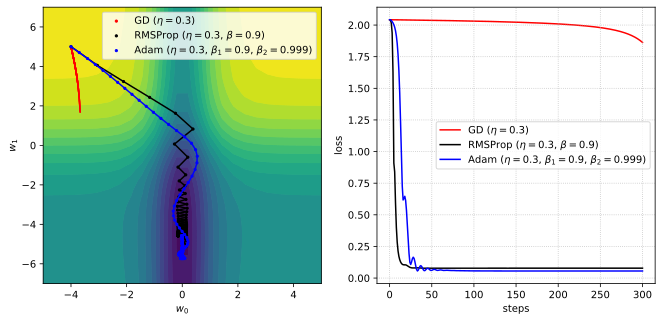

In [14]:
from functools import partial

fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, lr=0.3, w_init=[-4.0, 5.0], optim=GD, label=lambda lr: f"GD ($\eta={lr}$)", color="red",  zorder=1)
plot_gd_steps(ax, lr=0.3, w_init=[-4.0, 5.0], optim=partial(RMSProp, beta=0.9), label=lambda lr: f"RMSProp ($\eta={lr}$, " + r"$\beta=0.9$)", color="black", zorder=2)
plot_gd_steps(ax, lr=0.3, w_init=[-4.0, 5.0], optim=partial(Adam, beta1=0.9, beta2=0.999), label=lambda lr: f"Adam ($\eta={lr}$, " + r"$\beta_1=0.9$, $\beta_2=0.999$)", color="blue", zorder=2)

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

The effect of momentum can be seen by the dampening of oscillations. We can also see that the step size look quite uniform similar to RMSProp. Then auto-tuning kicks in to decrease the step size as the gradient decreases around the minimum. 

Trying out a larger learning rate:

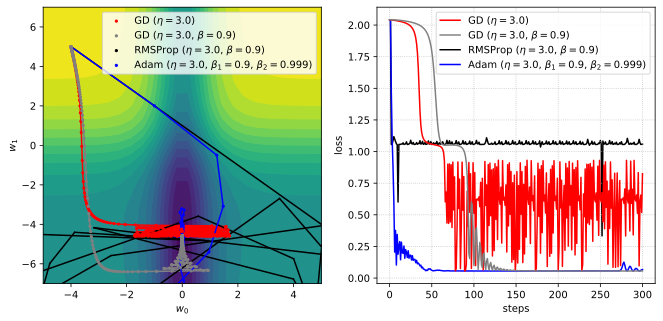

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, lr=3.0, w_init=[-4.0, 5.0], optim=GD, label=lambda lr: f"GD ($\eta={lr}$)", color="red",  zorder=3)
plot_gd_steps(ax, lr=3.0, w_init=[-4.0, 5.0], optim=partial(GD, momentum=0.9), label=lambda lr: f"GD ($\eta={lr}$, " + r"$\beta=0.9$)", color="gray",  zorder=3)
plot_gd_steps(ax, lr=3.0, w_init=[-4.0, 5.0], optim=partial(RMSProp, beta=0.9), label=lambda lr: f"RMSProp ($\eta={lr}$, " + r"$\beta=0.9$)", color="black", zorder=1)
plot_gd_steps(ax, lr=3.0, w_init=[-4.0, 5.0], optim=partial(Adam, beta1=0.9, beta2=0.999), label=lambda lr: f"Adam ($\eta={lr}$, " + r"$\beta_1=0.9$, $\beta_2=0.999$)", color="blue", zorder=2)

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

RMSProp does not perform well with large learning rate as it worsens oscillation. Adam converges fastest. We discuss this further below. Notice that Adam resumes oscillation near the end of training. This is an artifact of the second moment when the recent updates are small, it decreases making the effective step-size large. This does not happen with GD with momentum it seems to work better if tuned well, and is given enough training time. This is discussed further below.

## Learning rate scheduling

As we have seen above, learning rate must be tuned for GD with momentum to perform well. 
This is 
not as essential for optimizers which auto-tune the effective learning rate like Adam. 
The idea is to start with a high base learning rate, then decrease according to some heuristics (e.g. decrease when the loss plateaus).
For more example of schedules [see here](https://d2l.ai/chapter_optimization/lr-scheduler.html#schedulers).
An algorithm to find the base learning rate is [described here](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html). The idea is to tune the optimizer using a small fixed 
number of steps on the training set and choose a point where it starts to diverge.

Let us modify the training script to include a simple schedule:

In [16]:
def train_curve(optimizer, w_init=[5.0, 5.0], loss_fn=pathological_loss, num_steps=100):
    weights = nn.Parameter(torch.FloatTensor(w_init), requires_grad=True)
    optimizer = optimizer([weights])

    list_points = [torch.tensor([weights[0], weights[1], loss_fn(weights[0], weights[1])])]
    for _ in range(num_steps):
        
        # learning rate schedule (!)
        if _ % 100 == 0:
            optimizer.lr *= 0.5
        
        loss = loss_fn(weights[0], weights[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))

    points = torch.stack(list_points, dim=0).numpy()
    return points

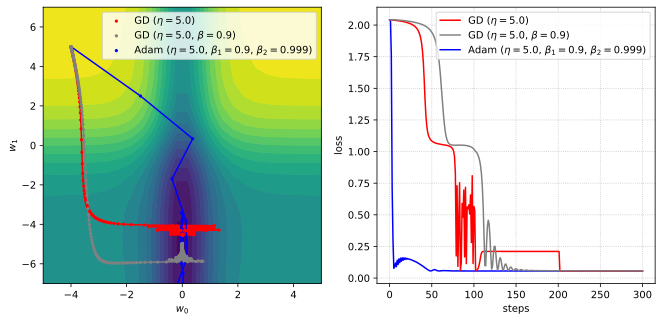

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, lr=5.0, w_init=[-4.0, 5.0], optim=GD, label=lambda lr: f"GD ($\eta={lr}$)", color="red",  zorder=3)
plot_gd_steps(ax, lr=5.0, w_init=[-4.0, 5.0], optim=partial(GD, momentum=0.9), label=lambda lr: f"GD ($\eta={lr}$, " + r"$\beta=0.9$)", color="gray",  zorder=3)
plot_gd_steps(ax, lr=5.0, w_init=[-4.0, 5.0], optim=partial(Adam, beta1=0.9, beta2=0.999), label=lambda lr: f"Adam ($\eta={lr}$, " + r"$\beta_1=0.9$, $\beta_2=0.999$)", color="blue", zorder=2)

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

Notice GD oscillation is decreased. Learning rate scheduling acts in place of the second-moment for Adam which auto-tunes the learning rate. Indeed, this looks like $\boldsymbol{\boldsymbol{\Theta}}^{t+1} = \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \frac{1}{\alpha^t} \, \boldsymbol{\mathsf{m}}^{t}$ where $\alpha^t = 2^{\lfloor t / 100 \rfloor}$ in this example. 


## Stochastic optimization (SGD)

Gradient descent computes gradients for each instance in the training set.
This can be expensive for large datasets.
But recall that training loss is just an estimate of the true loss 
however large the sample $\mathcal{D}$ is.
Hence, we can take a random subset 
$\mathcal{B} \subset \mathcal{D}$ such that $B = |\mathcal{B}| \ll |\mathcal{D}|$
and still get an unbiased estimate $\mathcal{L}_{\mathcal{B}} \approx \mathcal{L}.$ 
This is called **Stochastic Gradient Descent** (SGD).
It turns out that this works just as well in practice as regular GD, but a lot cheaper computationally.
Moreover, SGD has been shown to escape saddle points with some theoretical guarantees {cite}`dauphin2014`.
SGD update rule:

$$
\boldsymbol{\Theta}^{t+1} = \boldsymbol{\Theta}^t - \eta\; \nabla_{\boldsymbol{\Theta}}\, \mathcal L_{\mathcal{B}}(\boldsymbol{\Theta}^t)
$$

Typically, we take $B = 8, 32, 64, 128, 256.$ There are even cases where we take $B = 1$ when the network is too large that we cannot fit but one instance in memory. Note that SGD is essentially GD above it just replaces the function $f$ at each step with $\mathcal{L}_{\mathcal{B}}.$ Hence, all modifications of GD discussed are the same for SGD. 
The same results and observations also mostly hold. Although, $f$ now slightly changes at each step unlike before where it is fixed. This explains why we favored RMSProp style optimization which decouples gradient magnitude from the optimization.

**Remark.** In what follows, all GD modifications (Adam, etc.) will be assumed to be using stochastic sampling as well.

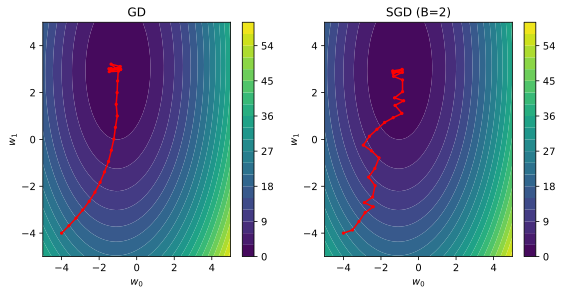

In [18]:
def plot_contourf(ax, data, target, w_hist, title="", N=50):
    x = np.linspace(-5, 5, N)
    y = np.linspace(-5, 5, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            Z[i, j] = loss(np.array([X[i, j], Y[i, j]]), data, target)

    for t in range(1, len(w_hist)):
        ax.plot([w_hist[t-1][0], w_hist[t][0]], [w_hist[t-1][1], w_hist[t][1]], color='red')

    c = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(w_hist[:, 0], w_hist[:, 1], marker='o', s=5, facecolors='red', zorder=2)
    ax.set_title(title)
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')
    plt.colorbar(c, ax=ax)


def loss(w, X, y):
    return ((X @ w - y)**2).mean()

def grad(w, X, y, B=None):
    """Gradient step for the MSE loss function"""
    dw = 2*((X @ w - y).reshape(-1, 1) * X).mean(axis=0)
    return dw / np.linalg.norm(dw)

def sgd(w0, X, y, eta=0.1, steps=10, B=32):
    """Return sequence of weights from GD."""
    w = np.zeros([steps, 2])
    w[0, :] = w0
    for j in range(1, steps):
        batch = torch.randint(0, len(X), size=(B,))
        u = w[j-1, :]
        w[j, :] = u - eta * grad(u, X[batch], y[batch])
    return w


# Generate data
n = 1000
X = np.zeros((n, 2))
X[:, 1] = np.random.uniform(low=-1, high=1, size=n)
X[:, 0] = 1
w_min = np.array([-1, 3])
y = (X @ w_min) + 0.05 * np.random.randn(n)  # data: y = -1 + 3x + noise

# Gradient descent
w_init = [-4, -4]
w_step_gd = sgd(w_init, X, y, eta=0.5, steps=30, B=len(X))
w_step_sgd = sgd(w_init, X, y, eta=0.5, steps=30, B=2)

# Create a figure and two subplots
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Call the functions with the respective axes
plot_contourf(ax1, X, y, w_step_gd)
plot_contourf(ax2, X, y, w_step_sgd)
plt.tight_layout()
ax1.set_title("GD")
ax2.set_title("SGD (B=2)")
plt.show()

**Remark.** Randomly sampling from $N \gg 1$ points at each step is expensive. Instead, we typically just shuffle the dataset once, then iterate over it with slices of size $B$ essentially sampling without replacement. One such pass over the dataset is called an **epoch**. This is done for example when using PyTorch DataLoaders.

In [19]:
from torch.utils.data import DataLoader

train_loader = DataLoader(torch.arange(10), batch_size=2, shuffle=True)

print("Epoch 1:")
print(list(train_loader))
print()
print("Epoch 2:")
print(list(train_loader))

Epoch 1:
[tensor([9, 2]), tensor([3, 5]), tensor([1, 4]), tensor([6, 0]), tensor([7, 8])]

Epoch 2:
[tensor([1, 9]), tensor([0, 4]), tensor([7, 5]), tensor([2, 3]), tensor([8, 6])]


**Remark.** SGD with momentum has been known to generalize better than Adam if you have resources to train with many epochs and tune the hyperparameters. Results from {cite}`sgd_better_than_adam` show that adaptively scaling each gradient coordinate well diminishes anisotropic structure of gradient noise and exponential gradient average in Adam smooths its gradient and leads to lighter gradient noise tails than SGD. So SGD is more locally unstable than Adam at sharp minima, as flat minima often generalize better than sharp ones {cite}`sharp_minima_bad`. But Adam is easier to use out of the box. In the next section, we talk about strategies on tuning SGD.

## Tuning optimizers

**Batch size.** Larger batch size means less gradient nose. This is safer but more expensive.
Some networks such as GANs require large $B$. But there are cases where we have to use $B = 1$ for large
networks. Reasonably large batch sizes (large but still small enough to have some randomness) does not 
seem to have any negative effect on generalization.

**Learning rate.** As mentioned above, a good strategy is to start with a large learning rate and
decay it over time. We can choose a large learning rate such that the network does not diverge but
still is able to jump around the surface to explore and not get stuck in local minima. 

**Momentum.** The default values $0.9$ and $0.99$ are good starting point. For Adam, we like to
keep the default parameters. If we have resources, and we want to push test performance, we can
tune SGD with momentum. But Adam already works well out of the box.

**Splitting strategy.** In principle, training hyperparameters are concerned with training 
and not generalization. As in the previous notebook, we regularize networks in various ways
to get good test performance. However, the situation is more complex with SGD where stochasticity
contributes to regularization. For example, when gradients differ then SGD is still in the learning
regime, but when the gradients are the same despite different samples, the network is starting to 
overfit. So in practice, hyperparameters are tuned on the validation set as well. This comes at a
cost but there does not seem to be any negative effect on performance since this is just another 
sample of the underlying distribution.

---

■